# CNN + MaxPool
CNN with GenCode 43 data.
Merge cell lines using average of the antilogs.
Ten rounds of CV.
Use class_weights for balanced predictions.
Return to 3 epochs of training.

Analyze the effect of using all transcripts and the GMM threshold.

Dense activation = sigmoid.

TO DO:
* Retain best model.

In [11]:
from datetime import datetime
print(datetime.now())

2023-03-09 19:30:02.577249


In [12]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [13]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=12
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.1


In [14]:
RCI_FILE       = 'train.lncRNA_RCI.csv'
SEQUENCE_FILE  = 'train.all_lncRNA_transcripts.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [15]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [16]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [17]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS,activation='sigmoid')
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [18]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-09 19:30:05.139968
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [19]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        # gene_index is ndarray with subset of indices of all_ids
        subsetX=[]
        subsetY=[]
        for i in gene_index:
            gene_id,tran_id = self.all_ids[i]
            oneX            = self.all_seqs[i]
            oneY            = self.rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            gmm = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            gmm.fit(rci_values)
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def do_cross_validation(self,repetition):
        fold=0
        print()
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True) # random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Repetition',repetition,'Fold',fold)
            X_train,y_rci = self._get_X_y(train_index) 
            self._prepare_threshold(y_rci)  # use train subset only!
            self._explain_threshold()
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index)  
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None
            cw = class_weight.compute_class_weight(
                'balanced', classes=[0,1], y=y_train)
            cwd = {0: cw[0], 1: cw[1]}

            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
                class_weight=cwd, validation_data=(X_valid,y_valid) ) 
            
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
            self._show_sizes('Train',y_train)
            self._show_sizes('Valid',y_valid)
            self._show_sizes('Predict',yhat_classes)

            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            precision = precision_score(y_valid, yhat_classes)*100.
            recall = recall_score(y_valid, yhat_classes)*100.
            f1 = f1_score(y_valid, yhat_classes)*100.
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.
            mcc = matthews_corrcoef(y_valid, yhat_classes)

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)

                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()

            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
            self.cv_accuracy.append(accuracy)
            self.cv_precision.append(precision)
            self.cv_recall.append(recall)
            self.cv_f1.append(f1)
            self.cv_mcc.append(mcc)
            self.cv_auprc.append(auprc)
            self.cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()

        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


2023-03-09 19:30:05.332979
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.
Cross validation...

2023-03-09 19:30:35.844462
splitting
Repetition 1 Fold 1
Discriminator is GMM
Means [1.4941638360353375, -0.158246766032549]
Variances [2.37088891 7.20040532]
Priors [0.70873389 0.29126611]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:30:51.519356
PREDICT
2023-03-09 19:32:15.731015
train class weights 1:0  0.57: 4.31
Train 1:0 13649:1791 88.40%
Valid 1:0 3402:459 88.11%
Predict 1:0 3861:0 100.00%


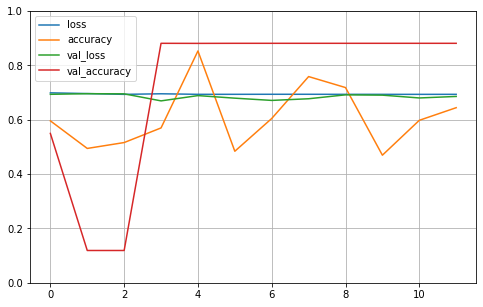

Compute valiation accuracy
Valid sizes (3861, 4997) (3861,)
Range of scores: 0.50469816 to 0.50496113
Score threshold 0.5


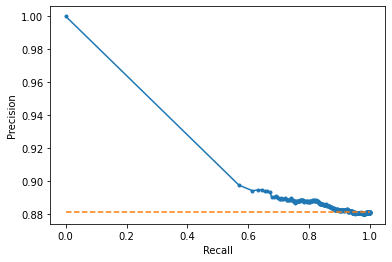

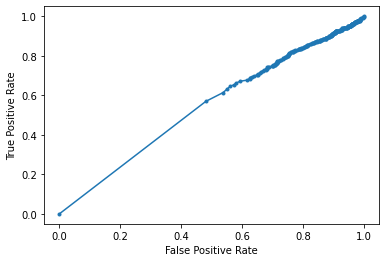

Accuracy: 88.11% Precision: 88.11% Recall: 100.00%
F1: 93.68% MCC: 0.00%
AUPRC: 92.26% AUROC: 54.40%
2023-03-09 19:32:17.169297
Repetition 1 Fold 2
Discriminator is GMM
Means [1.427989758213962, -0.1710430629019901]
Variances [2.38565236 7.8929299 ]
Priors [0.73190734 0.26809266]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:32:34.510554
PREDICT
2023-03-09 19:33:58.304966
train class weights 1:0  0.56: 4.75
Train 1:0 13816:1625 89.48%
Valid 1:0 3450:410 89.38%
Predict 1:0 1710:2150 44.30%


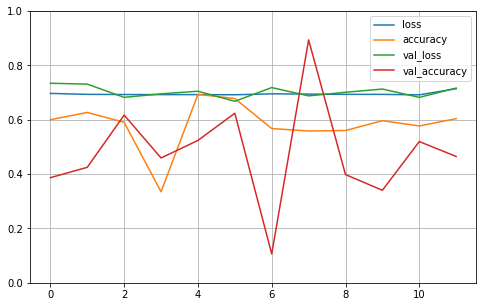

Compute valiation accuracy
Valid sizes (3860, 4997) (3860,)
Range of scores: 0.38744065 to 0.5608977
Score threshold 0.5


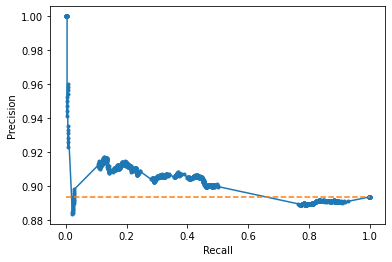

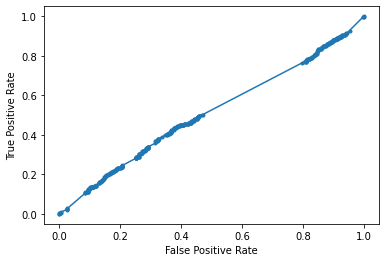

Accuracy: 46.48% Precision: 90.47% Recall: 44.84%
F1: 59.96% MCC: 0.03%
AUPRC: 90.05% AUROC: 51.01%
2023-03-09 19:34:00.382738
Repetition 1 Fold 3
Discriminator is GMM
Means [1.4208994026600974, -0.19505001884770498]
Variances [2.39422627 8.09182039]
Priors [0.73464746 0.26535254]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:34:22.072897
PREDICT
2023-03-09 19:35:30.043223
train class weights 1:0  0.56: 4.84
Train 1:0 13846:1595 89.67%
Valid 1:0 3447:413 89.30%
Predict 1:0 3860:0 100.00%


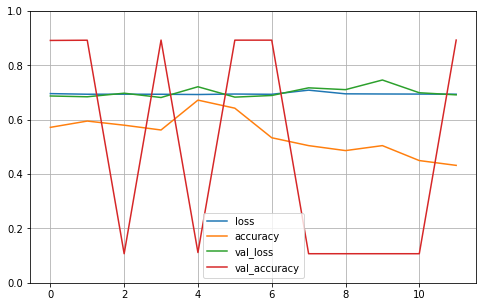

Compute valiation accuracy
Valid sizes (3860, 4997) (3860,)
Range of scores: 0.50104713 to 0.5010512
Score threshold 0.5


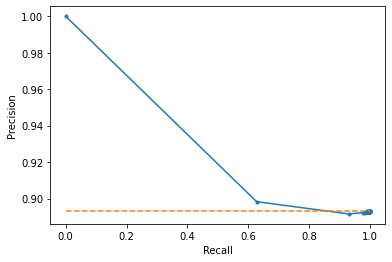

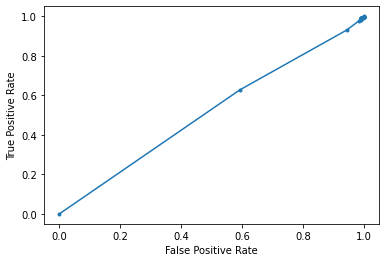

Accuracy: 89.30% Precision: 89.30% Recall: 100.00%
F1: 94.35% MCC: 0.00%
AUPRC: 92.87% AUROC: 51.32%
2023-03-09 19:35:31.453061
Repetition 1 Fold 4
Discriminator is GMM
Means [1.426672017153274, -0.18372024676554344]
Variances [2.4111145 7.9402415]
Priors [0.73124654 0.26875346]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:35:49.999227
PREDICT
2023-03-09 19:36:56.839436
train class weights 1:0  0.56: 4.74
Train 1:0 13813:1628 89.46%
Valid 1:0 3465:395 89.77%
Predict 1:0 0:3860  0.00%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


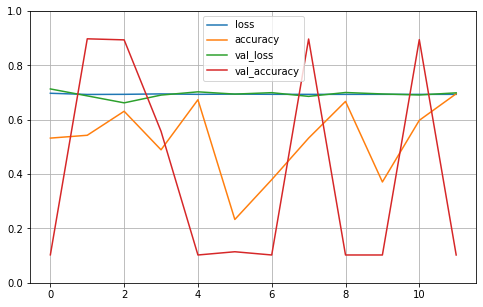

Compute valiation accuracy
Valid sizes (3860, 4997) (3860,)
Range of scores: 0.47306392 to 0.49645877
Score threshold 0.5


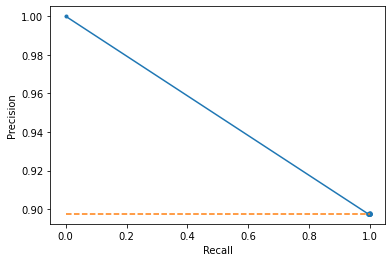

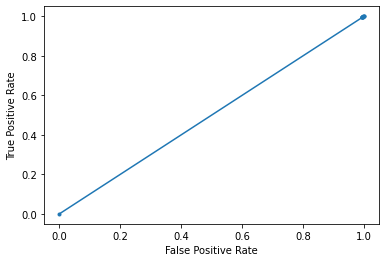

Accuracy: 10.23% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.00%
AUPRC: 94.85% AUROC: 49.94%
2023-03-09 19:36:58.303738
Repetition 1 Fold 5
Discriminator is GMM
Means [-0.21728147087262148, 1.4393169574223776]
Variances [8.14411747 2.43102097]
Priors [0.26232938 0.73767062]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:37:13.839966
PREDICT
2023-03-09 19:38:22.104936
train class weights 1:0  0.56: 4.84
Train 1:0 13847:1594 89.68%
Valid 1:0 3478:382 90.10%
Predict 1:0 1638:2222 42.44%


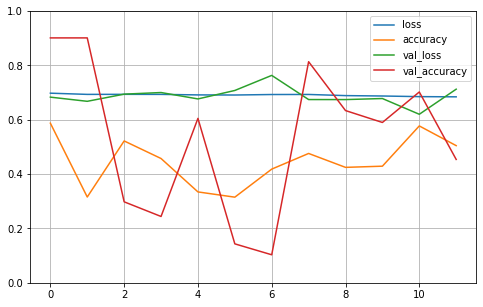

Compute valiation accuracy
Valid sizes (3860, 4997) (3860,)
Range of scores: 0.35238102 to 0.7226493
Score threshold 0.5


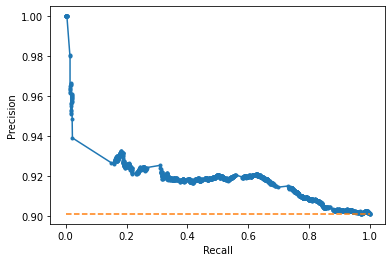

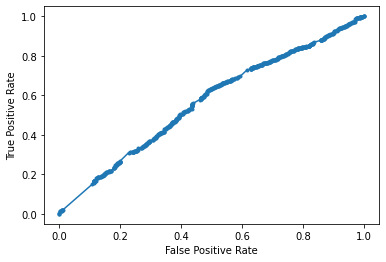

Accuracy: 45.39% Precision: 91.82% Recall: 43.24%
F1: 58.80% MCC: 0.05%
AUPRC: 91.92% AUROC: 56.55%
2023-03-09 19:38:23.655776


2023-03-09 19:38:25.329518
splitting
Repetition 2 Fold 1
Discriminator is GMM
Means [1.4660494288333958, -0.1812919176170628]
Variances [2.38460995 7.57493216]
Priors [0.71757038 0.28242962]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:38:39.480405
PREDICT
2023-03-09 19:39:45.942786
train class weights 1:0  0.56: 4.47
Train 1:0 13711:1729 88.80%
Valid 1:0 3457:404 89.54%
Predict 1:0 3861:0 100.00%


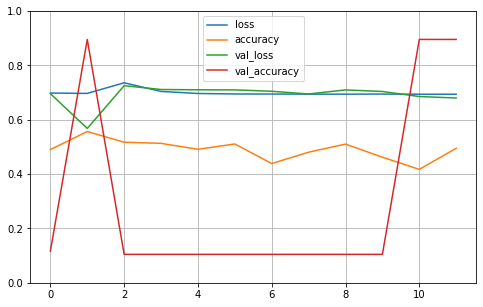

Compute valiation accuracy
Valid sizes (3861, 4997) (3861,)
Range of scores: 0.5083907 to 0.5084382
Score threshold 0.5


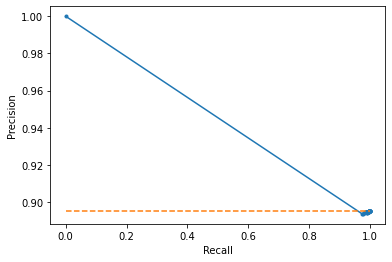

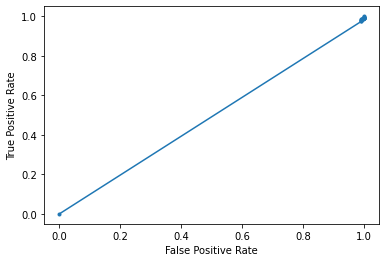

Accuracy: 89.54% Precision: 89.54% Recall: 100.00%
F1: 94.48% MCC: 0.00%
AUPRC: 94.55% AUROC: 49.08%
2023-03-09 19:39:47.372024
Repetition 2 Fold 2
Discriminator is GMM
Means [1.422234313698273, -0.20909767730500986]
Variances [2.41445818 8.00591595]
Priors [0.73367864 0.26632136]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:40:03.787116
PREDICT
2023-03-09 19:41:10.407929
train class weights 1:0  0.56: 4.81
Train 1:0 13835:1606 89.60%
Valid 1:0 3468:392 89.84%
Predict 1:0 18:3842  0.47%


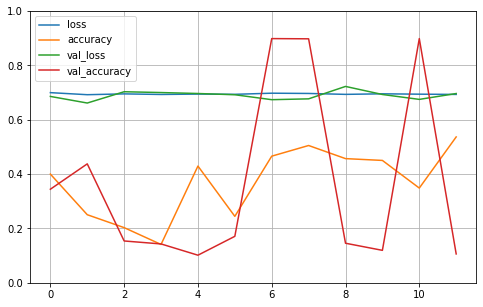

Compute valiation accuracy
Valid sizes (3860, 4997) (3860,)
Range of scores: 0.49296594 to 0.7311597
Score threshold 0.5


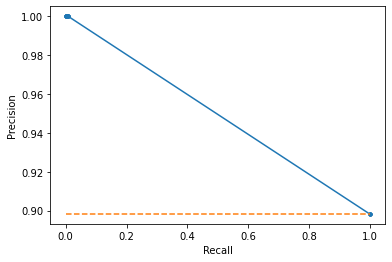

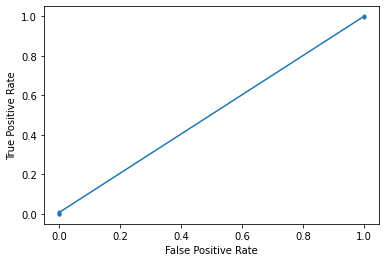

Accuracy: 10.62% Precision: 100.00% Recall: 0.52%
F1: 1.03% MCC: 0.02%
AUPRC: 94.95% AUROC: 50.32%
2023-03-09 19:41:11.821678
Repetition 2 Fold 3
Discriminator is GMM
Means [1.4478319264118154, -0.12101471590993099]
Variances [2.40292671 7.47257099]
Priors [0.71400342 0.28599658]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:41:30.683761
PREDICT
2023-03-09 19:42:38.099739
train class weights 1:0  0.56: 4.54
Train 1:0 13739:1702 88.98%
Valid 1:0 3426:434 88.76%
Predict 1:0 1940:1920 50.26%


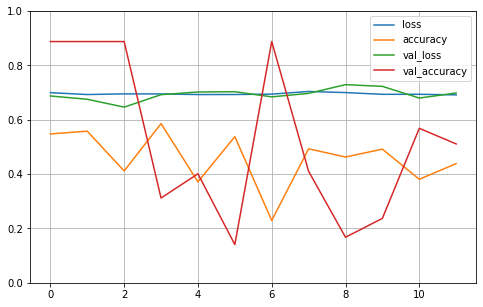

Compute valiation accuracy
Valid sizes (3860, 4997) (3860,)
Range of scores: 0.3779193 to 0.53059286
Score threshold 0.5


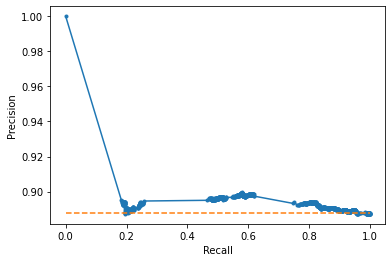

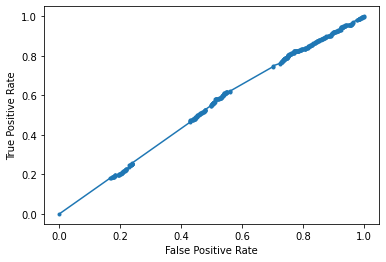

Accuracy: 51.09% Precision: 89.64% Recall: 50.76%
F1: 64.82% MCC: 0.03%
AUPRC: 90.35% AUROC: 52.82%
2023-03-09 19:42:39.612785
Repetition 2 Fold 4
Discriminator is GMM
Means [1.4351443966087551, -0.1861702370973672]
Variances [2.38465428 7.95925848]
Priors [0.73515253 0.26484747]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:42:55.241656
PREDICT
2023-03-09 19:44:19.044662
train class weights 1:0  0.56: 4.81
Train 1:0 13835:1606 89.60%
Valid 1:0 3433:427 88.94%
Predict 1:0 1555:2305 40.28%


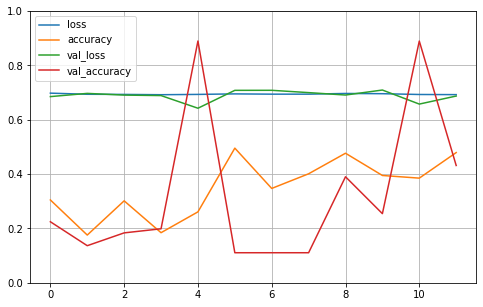

Compute valiation accuracy
Valid sizes (3860, 4997) (3860,)
Range of scores: 0.4732162 to 0.67019325
Score threshold 0.5


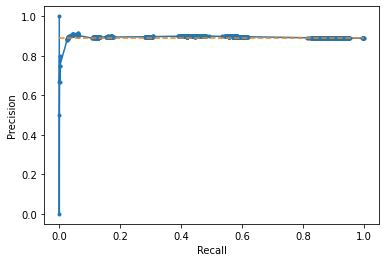

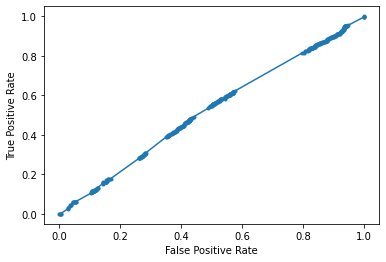

Accuracy: 43.16% Precision: 89.84% Recall: 40.69%
F1: 56.01% MCC: 0.02%
AUPRC: 89.29% AUROC: 52.22%
2023-03-09 19:44:21.477455
Repetition 2 Fold 5
Discriminator is GMM
Means [1.4383360226283413, -0.2133095702053331]
Variances [2.39981403 8.21895839]
Priors [0.74031843 0.25968157]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-09 19:44:39.766898
PREDICT
2023-03-09 19:46:03.575708
train class weights 1:0  0.55: 5.15
Train 1:0 13941:1500 90.29%
Valid 1:0 3483:377 90.23%
Predict 1:0 3860:0 100.00%


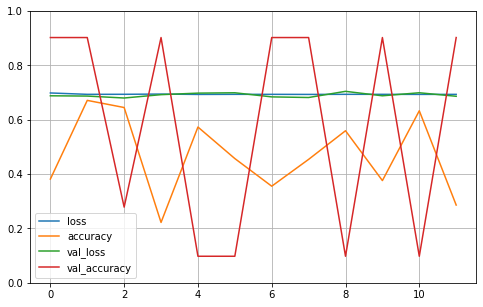

Compute valiation accuracy
Valid sizes (3860, 4997) (3860,)
Range of scores: 0.5042977 to 0.50436896
Score threshold 0.5


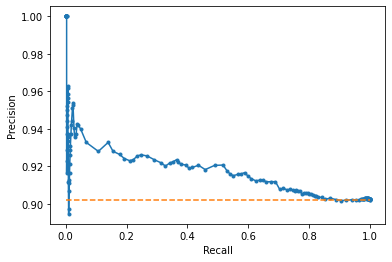

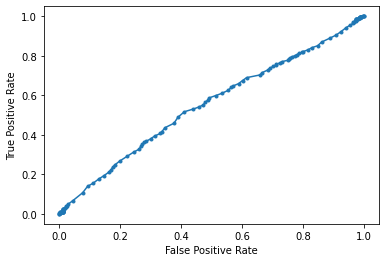

Accuracy: 90.23% Precision: 90.23% Recall: 100.00%
F1: 94.87% MCC: 0.00%
AUPRC: 91.74% AUROC: 54.97%
2023-03-09 19:46:05.912480

Completed cross validation 5 folds 12 epochs
Repeated for a total of 10 folds
 accuracy mean 56.42% std 31.59
 precision mean 81.89% std 28.97
 recall mean 58.01% std 40.09
 F1 mean 61.80% std 36.22
 MCC mean 0.02% std 0.02
 AUPRC mean 92.28% std 2.03
 AUROC mean 52.26% std 2.41

 accuracy [88.11188811188812, 46.47668393782383, 89.30051813471502, 10.233160621761659, 45.388601036269435, 89.53638953638954, 10.621761658031089, 51.0880829015544, 43.16062176165803, 90.23316062176166]
 precision [88.11188811188812, 90.46783625730994, 89.30051813471502, 0.0, 91.81929181929182, 89.53638953638954, 100.0, 89.63917525773196, 89.83922829581994, 90.23316062176166]
 recall [100.0, 44.84057971014493, 100.0, 0.0, 43.24324324324324, 100.0, 0.5190311418685121, 50.758902510216, 40.693271191377804, 100.0]
 F1 [93.68029739776951, 59.96124031007752, 94.34788558916108, 0.0, 58.7959

In [20]:
print(datetime.now())
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
loader = None  # drop K-mer cache to save RAM

print("Cross validation...")
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cvdo.set_sequences(allids,allseq)
cvdo.set_rci_map(gene_to_rci)
cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
# two rounds of 5 for 10 total
total_folds = 0
for F in range(2):
    total_folds += FOLDS
    cvdo.do_cross_validation(F+1)   
cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
    cvdo.get_statistics()
cvdo = None

def STD (values):
    return np.std(values,ddof=1)

print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print("Repeated for a total of %d folds" % total_folds)
print(" accuracy mean %.2f%% std %.2f" %  (np.mean(cv_accuracy),  STD(cv_accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(cv_precision), STD(cv_precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(cv_recall),    STD(cv_recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(cv_f1),        STD(cv_f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(cv_mcc),       STD(cv_mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(cv_auprc),     STD(cv_auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(cv_auroc),     STD(cv_auroc)))
print()
print(" accuracy" ,  cv_accuracy)
print(" precision" , cv_precision)
print(" recall" ,    cv_recall)
print(" F1" ,        cv_f1)
print(" MCC" ,       cv_mcc)
print(" AUPRC" ,     cv_auprc)
print(" AUROC" ,     cv_auroc)
print(datetime.now())